### Methodology
#### The expected content of the notebook:
    - Detection of time series changes in daily questionnaire data about fatigue

#### Data - daily questionnaire data of James (using OpenFace for windows)

In [1]:
# import sys
# import os
# import warnings

import pandas as pd
# from pandas.io.json import json_normalize #package for flattening json in pandas df
# from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
# import CRD_functions as crd

from jmspack.NLTSA import (ts_levels, 
                           distribution_uniformity, 
                           fluctuation_intensity, 
                           complexity_resonance, 
                           complexity_resonance_diagram,
                          cumulative_complexity_peaks,
                          cumulative_complexity_peaks_plot)
import miceforest as mf

import session_info

#### Display the session info of the notebook

In [2]:
session_info.show()

In [3]:
df = (pd.read_csv("data/user_351_smart_panel.csv")
      .rename(columns={"Unnamed: 0": "date"})
      .assign(date=lambda x: pd.to_datetime(x["date"]).dt.date)
      .drop("user_id", axis=1)
      .set_index("date")
     )

In [4]:
date_range = pd.date_range(df.reset_index().date.min(),
             df.reset_index().date.max())

In [5]:
df

,validated_physical,validated_cognitive,validated_motivational,fatigue,slider
date,,,,,
2020-07-15,1.496997,NaN,NaN,1.385599,NaN
2020-07-18,NaN,3.428084,NaN,3.334602,NaN
2020-07-19,NaN,0.664916,NaN,0.646784,NaN
2020-07-20,NaN,NaN,1.532818,1.294205,NaN
2020-07-21,1.496997,NaN,0.766409,2.032702,NaN
...,...,...,...,...,...
2021-05-27,NaN,NaN,2.938475,2.481045,NaN
2021-06-01,NaN,NaN,NaN,NaN,63.0
2021-06-07,NaN,1.951801,NaN,1.898576,NaN


In [6]:
df = df.reindex(date_range)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2020-07-15 to 2021-06-13
Freq: D
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   validated_physical      86 non-null     float64
 1   validated_cognitive     113 non-null    float64
 2   validated_motivational  77 non-null     float64
 3   fatigue                 190 non-null    float64
 4   slider                  62 non-null     float64
dtypes: float64(5)
memory usage: 15.7 KB


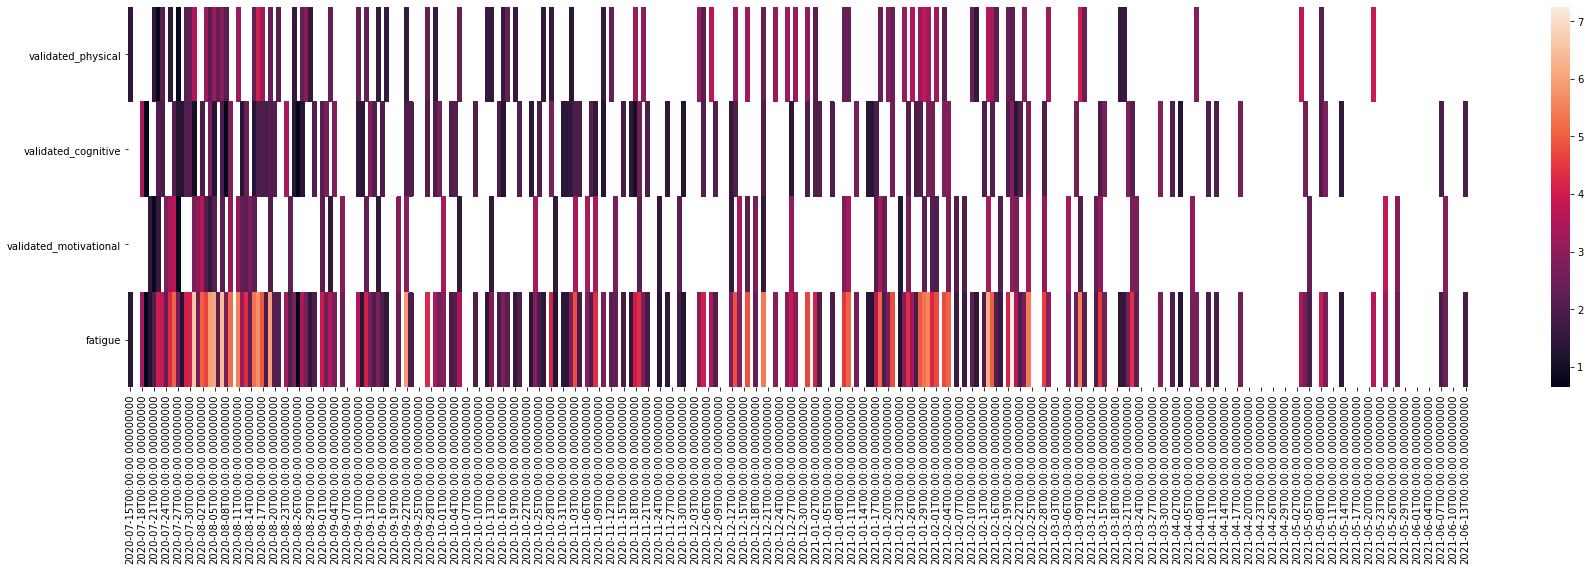

In [8]:
_ = plt.figure(figsize=(30, 7))
_ = sns.heatmap(data=df
                .drop("slider", axis=1)
#                 .assign(date=lambda x: pd.to_datetime(x["date"]).dt.date)
#                 .set_index("date")
                .T
               )

In [9]:
current_feature = "fatigue"

In [10]:
# _ = df.set_index("date", inplace=True)

## Impute the missing data

#### Looking at linear interpolation first

In [11]:
ts = df[current_feature].interpolate(method="polynomial", order=1)

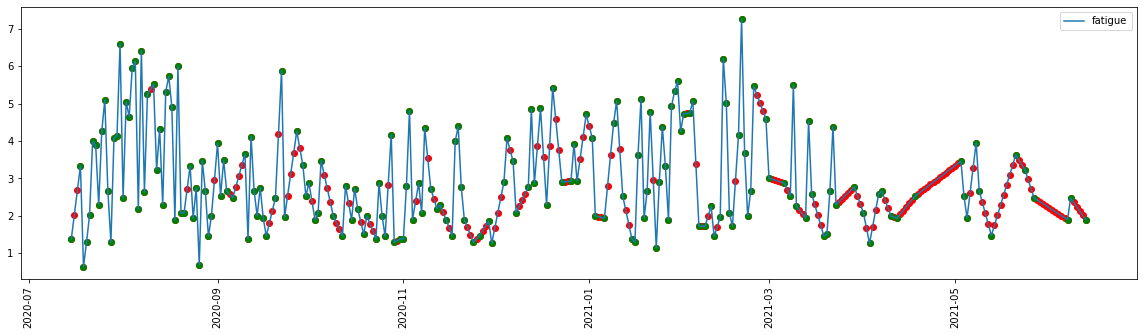

In [12]:
_ = plt.figure(figsize=(20, 5))
_ = plt.plot(ts, label=current_feature)
_ = plt.scatter(ts.index, ts.values, c="red")
_ = plt.scatter(df[current_feature].index, df[current_feature].values, c="green")
_ = plt.xticks(rotation=90)
_ = plt.legend()

#### Deciding on the MICE algorithm in the end

In [13]:
# Create kernel. 
kds = mf.KernelDataSet(
  df,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for N amount of iterations
kds.mice(iterations = 10)

# Return the completed kernel data
completed_data = kds.complete_data()

In [14]:
ts = completed_data[current_feature]

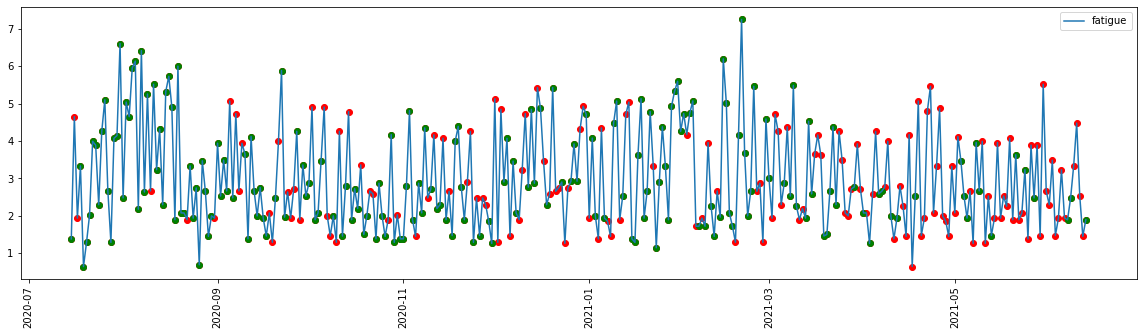

In [15]:
_ = plt.figure(figsize=(20, 5))
_ = plt.plot(ts, label=current_feature)
_ = plt.scatter(ts.index, ts.values, c="red")
_ = plt.scatter(df[current_feature].index, df[current_feature].values, c="green")
_ = plt.xticks(rotation=90)
_ = plt.legend()

In [16]:
ts_levels_df, _, _ = ts_levels(ts=ts.values,
    ts_x=ts.index,
    criterion='mse',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_leaf_nodes=30,
    plot=False,
    equal_spaced=True,
    n_x_ticks=10,
    figsize=(20, 5))

In [17]:
plot_df = ts_levels_df.drop("t_steps", axis=1).melt("ts_x")

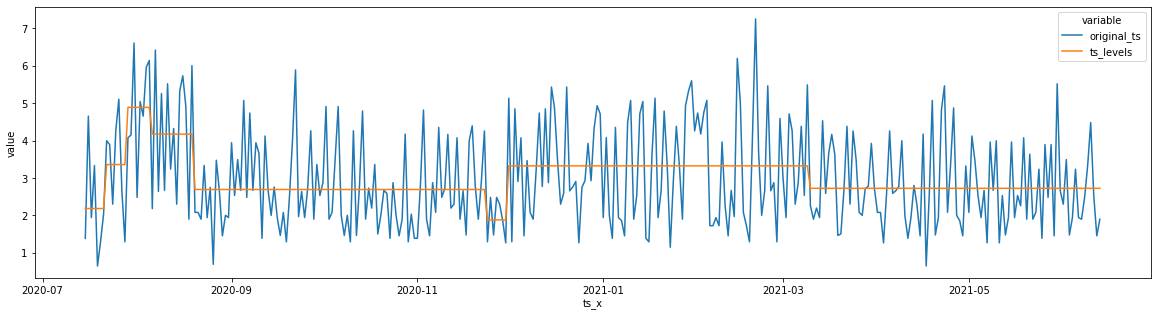

In [18]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=plot_df, x="ts_x", y="value", hue="variable")

In [19]:
def change_profile(x, window_size):
#     window_size = 5
#     x=ts
    window_range = np.arange(0, len(x)-window_size, window_size)

    cp_df = pd.DataFrame()
    for window_begin in window_range:
        window_mean = x.iloc[window_begin: window_begin + window_size].mean()
        window_sum = x.iloc[window_begin: window_begin + window_size].sum()
        
#         current_cp_df = x.iloc[window_begin: window_begin + window_size] - window_mean

        current_cp_df = (x.iloc[window_begin: window_begin + window_size] - window_sum) / window_size
        cp_df = pd.concat([cp_df, current_cp_df])
        
    return cp_df[0]

In [20]:
ts_cp = change_profile(ts, window_size=6)

In [21]:
ts_levels_df, _, _ = ts_levels(ts=ts_cp.values,
    ts_x=ts_cp.index,
    criterion='mse',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_leaf_nodes=30,
    plot=False,
    equal_spaced=True,
    n_x_ticks=10,
    figsize=(20, 5))

In [22]:
plot_df = ts_levels_df.drop("t_steps", axis=1).melt("ts_x")

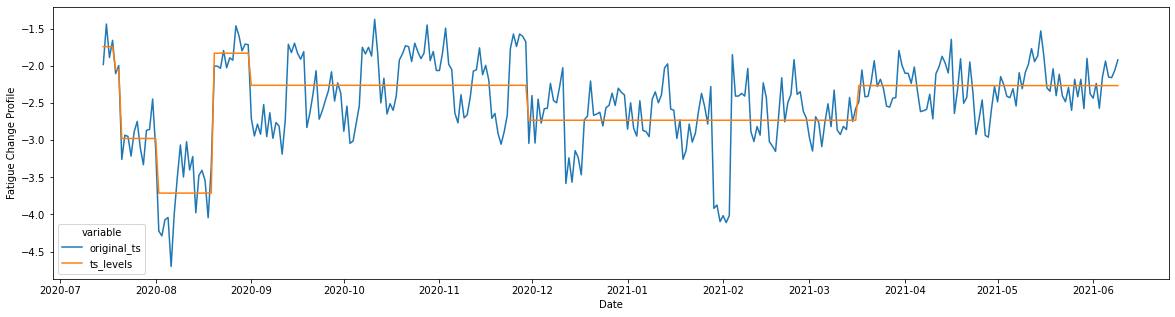

In [23]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=plot_df, x="ts_x", y="value", hue="variable")
_ = plt.ylabel("Fatigue Change Profile")
_ = plt.xlabel("Date")

In [24]:
plot_df = (ts_levels_df
 .drop(["t_steps"], axis=1)
 .rename(columns={"original_ts": "Fatigue_Change_Profile",
                  "ts_levels": "Fatigue_levels",
                  "ts_x": "Date"})
           .assign(Date=lambda x: x["Date"].astype(str))
 .set_index("Date")
)

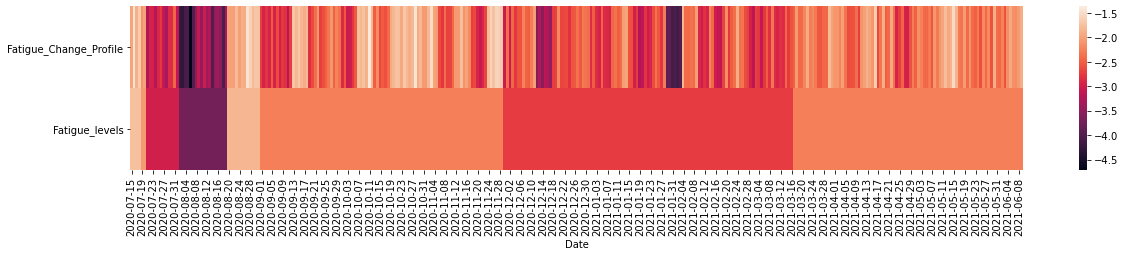

In [25]:
_ = plt.figure(figsize=(20, 3))
_ = sns.heatmap(plot_df.T)

In [26]:
fi_df = pd.DataFrame(fluctuation_intensity(pd.DataFrame(ts_cp), win=7, xmin=0, xmax=1, col_first=1, col_last=1)).rename(columns={0: current_feature})

In [27]:
di_df = pd.DataFrame(distribution_uniformity(pd.DataFrame(ts_cp), win=7, xmin=0, xmax=1, col_first=1, col_last=1)).rename(columns={0: current_feature})

In [28]:
cr_df = complexity_resonance(fi_df, di_df).rename(columns={0: current_feature})

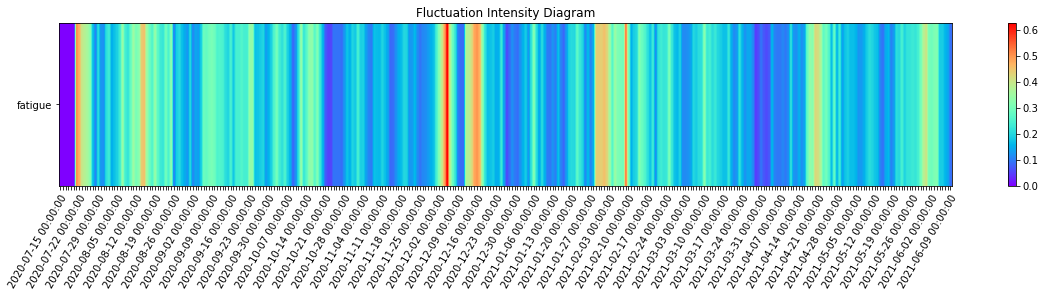

In [29]:
_ = complexity_resonance_diagram(fi_df, cmap_n=12, plot_title='Fluctuation Intensity Diagram', labels_n=7, figsize=(20, 3))

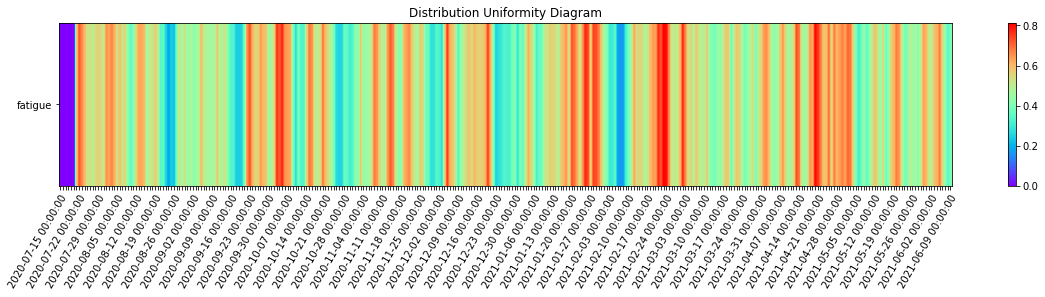

In [30]:
_ = complexity_resonance_diagram(di_df, cmap_n=12, plot_title='Distribution Uniformity Diagram', labels_n=7, figsize=(20, 3))

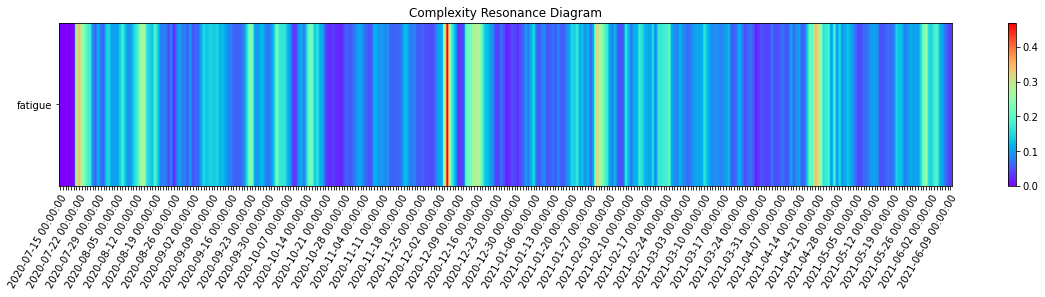

In [31]:
_ = complexity_resonance_diagram(cr_df, cmap_n=12, plot_title='Complexity Resonance Diagram', labels_n=7, figsize=(20, 3))

In [32]:
cumulative_complexity_peaks_df, significant_peaks_df = cumulative_complexity_peaks(df=cr_df,
                                                                                    significant_level_item = 0.05,
    significant_level_time = 0.05)

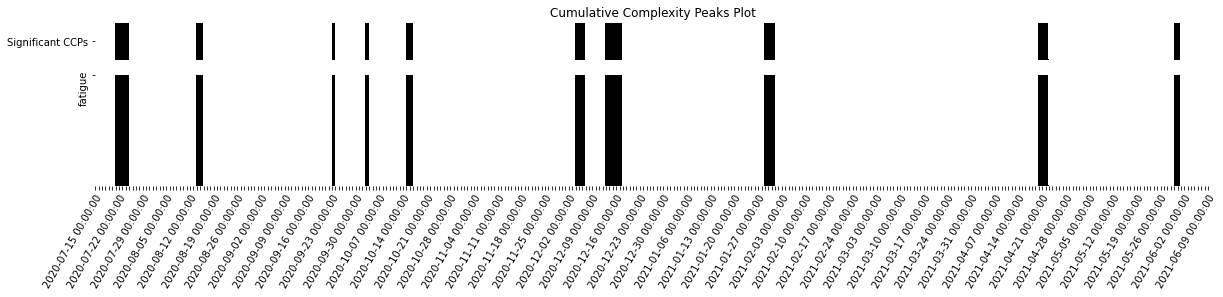

In [33]:
_ = cumulative_complexity_peaks_plot(cumulative_complexity_peaks_df=cumulative_complexity_peaks_df, 
                                     significant_peaks_df=significant_peaks_df,
                                    figsize = (20, 3),
    height_ratios = [1, 3],
    labels_n = 7)

# Dates of interest

In [34]:
significant_peaks_df[significant_peaks_df["Significant CCPs"]==1]

,Significant CCPs
2020-07-21,1.0
2020-07-22,1.0
2020-07-23,1.0
2020-07-24,1.0
2020-08-14,1.0
2020-08-15,1.0
2020-09-23,1.0
2020-10-03,1.0
2020-10-15,1.0
2020-10-16,1.0


## Running the CRDs on all the columns out of curiosity (not very reliable due to amount of missingness)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2020-07-15 to 2021-06-13
Freq: D
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   validated_physical      86 non-null     float64
 1   validated_cognitive     113 non-null    float64
 2   validated_motivational  77 non-null     float64
 3   fatigue                 190 non-null    float64
 4   slider                  62 non-null     float64
dtypes: float64(5)
memory usage: 23.8 KB


In [36]:
completed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2020-07-15 to 2021-06-13
Freq: D
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   validated_physical      334 non-null    float64
 1   validated_cognitive     334 non-null    float64
 2   validated_motivational  334 non-null    float64
 3   fatigue                 334 non-null    float64
 4   slider                  334 non-null    float64
dtypes: float64(5)
memory usage: 23.8 KB


In [37]:
# completed_data.describe()

In [38]:
scal_df = pd.DataFrame(MinMaxScaler().fit_transform(completed_data), 
             columns = completed_data.columns,
            index = completed_data.index)

In [39]:
fi_df = pd.DataFrame(fluctuation_intensity(scal_df, win=7, xmin=0, xmax=1, col_first=1, col_last=completed_data.shape[1]))#.rename(columns={0: current_feature})

In [40]:
di_df = pd.DataFrame(distribution_uniformity(scal_df, win=7, xmin=0, xmax=1, col_first=1, col_last=completed_data.shape[1]))#.rename(columns={0: current_feature})

In [41]:
cr_df = complexity_resonance(fi_df, di_df)#.rename(columns={0: current_feature})

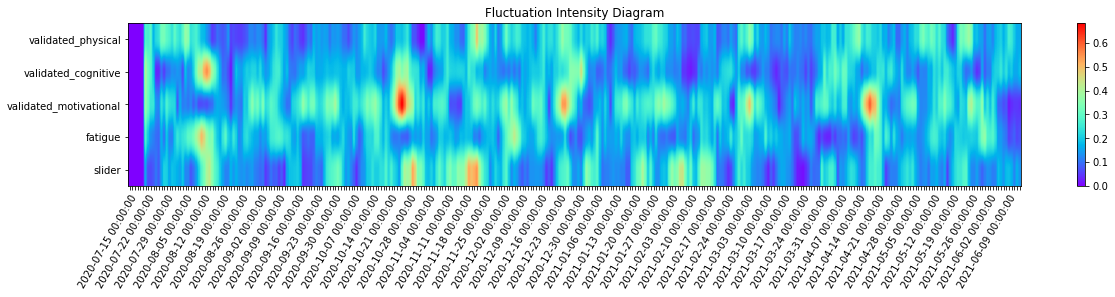

In [42]:
_ = complexity_resonance_diagram(fi_df, cmap_n=12, plot_title='Fluctuation Intensity Diagram', labels_n=7, figsize=(20, 3))

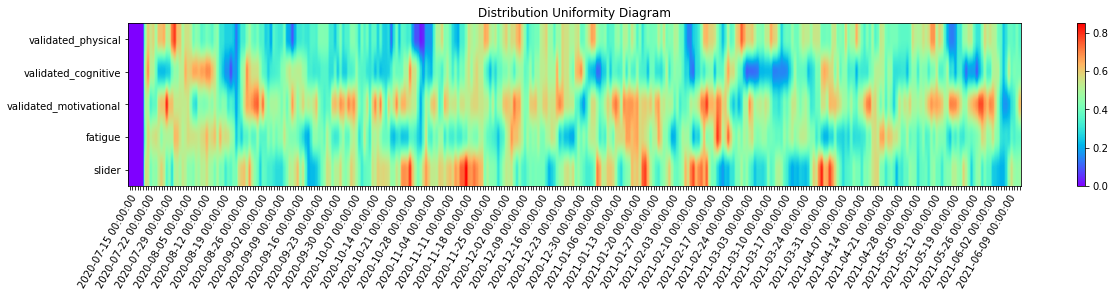

In [43]:
_ = complexity_resonance_diagram(di_df, cmap_n=12, plot_title='Distribution Uniformity Diagram', labels_n=7, figsize=(20, 3))

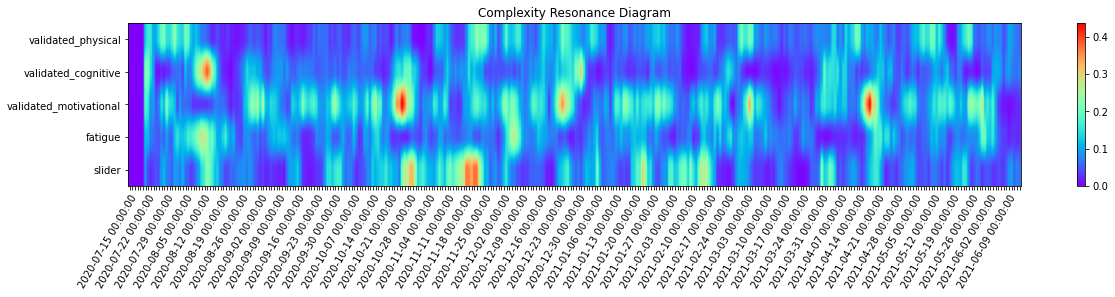

In [44]:
_ = complexity_resonance_diagram(cr_df, cmap_n=12, plot_title='Complexity Resonance Diagram', labels_n=7, figsize=(20, 3))

In [45]:
cumulative_complexity_peaks_df, significant_peaks_df = cumulative_complexity_peaks(df=cr_df,
                                                                                    significant_level_item = 0.05,
    significant_level_time = 0.05)

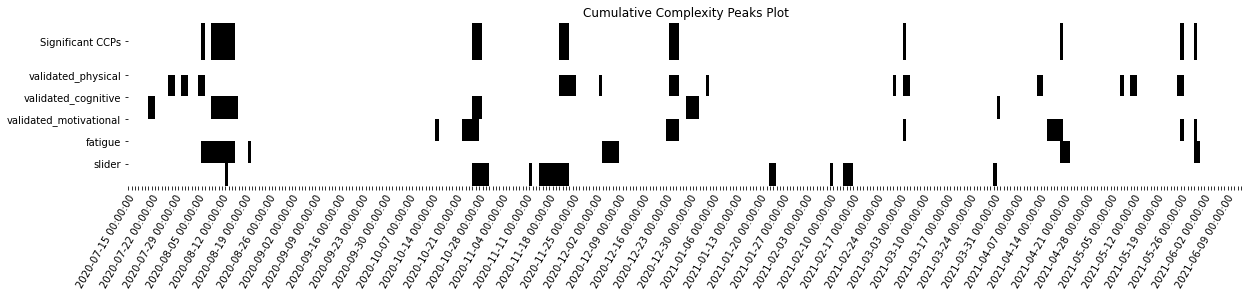

In [46]:
_ = cumulative_complexity_peaks_plot(cumulative_complexity_peaks_df=cumulative_complexity_peaks_df, 
                                     significant_peaks_df=significant_peaks_df,
                                    figsize = (20, 3),
    height_ratios = [1, 3],
    labels_n = 7)